In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.integrate import solve_ivp

In [43]:
def cp_ig_coeff_pseudo(kw , w): #T IN KELVIN  #joule/mole
    a0 = -1.41779 + 0.11828 * kw
    a1 = -1 * (6.99724 - 8.69326*kw + 0.27715*kw**2) * 10**(-4)
    a2 = -2.2582 * 10**(-6)

    b0 = 1.09223 - 2.48245*w
    b1 = -1 * (3.434 - 7.14*w) * 10**(-3)
    b2 = -1 * (7.2661 - 9.2561*w) * 10**(-7)

    c = ( ( (12.8-kw)*(10-kw) ) / (10*w) )**2

    return a0 , a1 , a2 , b0 , b1 , b2 , c

def cp_liq_coeff_pseudo(kw , sg ): #kj/kg.k ----> convert it to kmole then multiply by mwt ---> kj/kmole.k
   
   a1 = -4.90383 + kw*(0.099319 + 0.104281*sg) + ((4.81407 - 0.194833*kw)/sg)
   a2 = (7.53621 + 6.21461 * kw) * (1.12172 - (0.27634/sg)) * 10**(-4)
   a3 = -1*(1.35652 + 1.11863*kw)* (2.9027 - (0.70958/sg)) * 10**(-7)
   
   
   return  a1 , a2 , a3

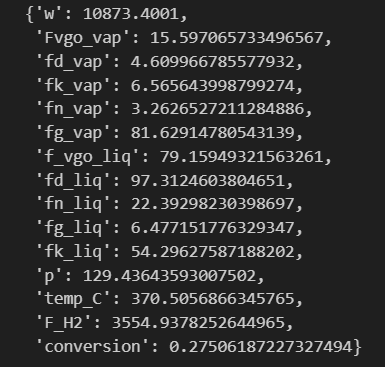

In [44]:
#flow rates
Fvgo_vap = 15.597 #
fd_vap   = 4.6099#
fk_vap   = 6.5656#
fn_vap   = 3.2626#
fg_vap   = 81.6291#
f_vgo_liq= 79.1594#
fd_liq   = 97.3124#
fn_liq   = 22.3929#
fg_liq   = 6.4771#
fk_liq   = 54.2962#
f_r_liq  = 4.745247617
f_r_vap  = 0.005588344
F_H2     = 3554.9378 + 96.33637060041967
F_H2S_liq = 18.06256176
F_H2S_vap = 297.7673451
F_NH3_vap = 2.52506041
F_NH3_liq = 0.149586238


In [45]:
f_tot_o_vap = Fvgo_vap + fd_vap + fk_vap + fn_vap + fg_vap + F_H2 + F_H2S_vap + F_NH3_vap  + f_r_vap
f_tot_o_vap

4063.2363644544203

In [46]:
f_tot_o_liq = f_vgo_liq + fd_liq + fn_liq + fg_liq + fk_liq + f_r_liq + F_H2S_liq + F_NH3_liq + f_r_liq
f_tot_o_liq

287.34064323200005

In [47]:
vo_liq = 1.237*f_tot_o_liq * 8314 * (368.4+273.15) / (129.43643593007502*101325)
vo_liq

144.5553369367564

In [48]:
MWT_o = 7.210671744
ro_o = (129.43643593007502*101325 * MWT_o) / (8314 * (368.4+273.15))
ro_o

17.729984432877032

In [49]:
def system(w , y):
#هنشوف حوار ال RESIDUE
    FF_vap , FD_vap , FK_vap  ,FN_vap , FG_vap , FF_liq , FD_liq , FK_liq , FN_liq , FG_liq , p  ,T ,F_H2 = y

  
    po = 129.43643593007502  #bar
    To = 368.4+ 273.15 #k
    #T = 368.4 + 273.15
    #p = 129.5
    ro_bulk = 654
    phai = 0.7384
    ro_cat = ro_bulk / (1-phai)
    F_tot_o_vap = 4063.2363644544203
    vo_vap = F_tot_o_vap * 8314 * To / (po * 101325) #m3/hr
    
    vo_liq = 144.5553369367564  #m3/hr
    
    #z_liq_60 =1.716 
    #zo_vap =1.037 
    #z_liq = 1.276  

    CT_o_vap = (po*101325) / ( To * 8314) #kmole/m3
    #print(CT_o_vap)
    FI_vap = 300.2924055 #kmole/hr

    Residue_vap = 0.005588344
    Residue_liq = 4.745247617
    #vap phase:
   #------------ 
    #CT_o_vap = (po*101325) / (8314 * (to + 273.15)) #po bar , to deg c  pa/(J/mole.k) * k 
    F_tot_vap = FF_vap + FD_vap + FN_vap + FK_vap  +FG_vap  + FI_vap + F_H2 + Residue_vap  #kmole/hr

    C_F_vap   = CT_o_vap * FF_vap   * p * To / (F_tot_vap * po * T)  #kmole/m3
    C_N_vap   = CT_o_vap * FN_vap   * p * To / (F_tot_vap * po * T)  #kmole/m3
    C_D_vap   = CT_o_vap * FD_vap   * p * To / (F_tot_vap * po * T)  #kmole/m3
    C_K_vap   = CT_o_vap * FK_vap   * p * To / (F_tot_vap * po * T)  #kmole/m3

    

    #MWTs
    MWT_VGO = 447.8479509
    MWT_N   = 114.9170391
    MWT_D   = 292.7362979
    MWT_K   = 170.23913
    MWT_G   = 16.56482354
    MWT_R   = 759.9991037

    K_FD = 4           * np.exp( (23.51 * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    K_DK = 0.862       * np.exp( (45.39 * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    K_FK = 1.01        * np.exp( (49.63 * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    K_FN = 2.18*10**-5 * np.exp( (41.34 * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    K_FG = 0.745       * np.exp( (5.61  * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    K_DN = 2.53        * np.exp( (45.72 * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    K_DG = 8.04*10**-29* np.exp( (87.38 * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    K_KN = 0.54        * np.exp( (22.13 * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    K_KG = 2.08*10**-3 * np.exp( (0.13  * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    K_NG = 12.43       * np.exp( (0     * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    

    #rate equations for vapor phase
    r_F_vap = -(C_F_vap) * (K_FD + K_FK + K_FG) / ro_bulk
    r_D_vap = (K_FD * (C_F_vap ) - K_DK * (C_D_vap ) - K_DN * (C_D_vap )) / ro_bulk
    r_K_vap = (K_FK * (C_F_vap ) + K_DK * (C_D_vap ) - K_KN * (C_K_vap )) / ro_bulk
    r_N_vap = (K_FN * (C_F_vap ) + K_DN * (C_D_vap ) + K_KN * (C_K_vap ) - K_NG * (C_N_vap)) / ro_bulk
    r_G_vap = (K_FG * (C_F_vap ) + K_DG * (C_D_vap ) + K_KG * (C_K_vap ) + K_NG * (C_N_vap)) / ro_bulk
    
   #mole balance for vapors
    dF_F_vap_dw = r_F_vap
    dF_D_vap_dw = r_D_vap
    dF_K_vap_dw = r_K_vap
    dF_N_vap_dw = r_N_vap
    dF_G_vap_dw = r_G_vap



    C_F_liq   = FF_liq / vo_liq  #kmole/m3
    C_N_liq   = FN_liq / vo_liq  #kmole/m3
    C_D_liq   = FD_liq / vo_liq  #kmole/m3
    C_K_liq   = FK_liq / vo_liq  #kmole/m3

    #rate equations for liq phase
    r_F_liq = -(C_F_liq) * (K_FD + K_FK + K_FG) / ro_bulk
    r_D_liq = (K_FD * (C_F_liq ) - K_DK * (C_D_liq ) - K_DN * (C_D_liq )) / ro_bulk
    r_K_liq = (K_FK * (C_F_liq ) + K_DK * (C_D_liq ) - K_KN * (C_K_liq )) / ro_bulk
    r_N_liq = (K_FN * (C_F_liq ) + K_DN * (C_D_liq ) + K_KN * (C_K_liq ) - K_NG * (C_N_liq)) / ro_bulk
    r_G_liq = (K_FG * (C_F_liq ) + K_DG * (C_D_liq ) + K_KG * (C_K_liq ) + K_NG * (C_N_liq ))/ ro_bulk

    #mole balance for liquids
    dF_F_liq_dw = r_F_liq
    dF_D_liq_dw = r_D_liq
    dF_K_liq_dw = r_K_liq
    dF_N_liq_dw = r_N_liq
    dF_G_liq_dw = r_G_liq
    
    

    #energy balance 

    a0_VGO_vap , a1_VGO_vap , a2_VGO_vap , b0_VGO_vap , b1_VGO_vap , b2_VGO_vap , c_VGO_vap = cp_ig_coeff_pseudo(kw = 11.83301505, w = 1.046734155)
    a0_D_vap , a1_D_vap , a2_D_vap , b0_D_vap , b1_D_vap , b2_D_vap , c_D_vap = cp_ig_coeff_pseudo(kw = 11.82860779, w = 0.77914103)
    a0_K_vap , a1_K_vap , a2_K_vap , b0_K_vap , b1_K_vap , b2_K_vap , c_K_vap = cp_ig_coeff_pseudo(kw = 11.93827339, w = 0.518610817)
    a0_N_vap , a1_N_vap , a2_N_vap , b0_N_vap , b1_N_vap , b2_N_vap , c_N_vap = cp_ig_coeff_pseudo(kw = 12.20555753, w = 0.345207156)
    #a0_G_vap , a1_G_vap , a2_G_vap , b0_G_vap , b1_G_vap , b2_G_vap , c_G_vap = cp_ig_coeff_pseudo(kw = 19.41, w = 1.47E-02)
    a0_R_vap , a1_R_vap , a2_R_vap , b0_R_vap , b1_R_vap , b2_R_vap , c_R_vap = cp_ig_coeff_pseudo(kw = 11.81969833, w = 1.558194126) 

    a1_VGO_liq , a2_VGO_liq , a3_VGO_liq  = cp_liq_coeff_pseudo(kw = 11.833263  , sg = 0.922061456)  
    a1_D_liq   , a2_D_liq   , a3_D_liq    = cp_liq_coeff_pseudo(kw = 11.82860779, sg = 0.872109193)
    a1_K_liq   , a2_K_liq   , a3_K_liq    = cp_liq_coeff_pseudo(kw = 11.93827339, sg = 0.803929666)
    a1_N_liq   , a2_N_liq   , a3_N_liq    = cp_liq_coeff_pseudo(kw = 12.20555753, sg = 0.734974159)
    a1_G_liq   , a2_G_liq   , a3_G_liq    = cp_liq_coeff_pseudo(kw = 13         , sg = 0.566285714)  #problema
    a1_R_liq   , a2_R_liq   , a3_R_liq    = cp_liq_coeff_pseudo(kw = 11.81969833, sg = 0.991019934) 
    
    octane_nbp = 125.6700073       
    hexa_nbp   = 286.7900024       
     

    #lambda_nbp_H2     = 1334.6  #j/mol
    lambda_nbp_hexa   = 51142.9 #j/mol
    lambda_nbp_octane = 34940.8 #j/mol



    lambda_transform_octane = lambda_nbp_octane *  ( (568.83 - 25)/(568.83 - octane_nbp)  )**0.38
    lambda_transform_hexa   = lambda_nbp_hexa   *  ( (720.6 - 25 )/(568.83 - hexa_nbp  )  )**0.38
    

    delta_H_ig_octane_298_T = 29.053 * (T - 298.15) + 0.5 * 0.58016   * (T**2 - 298.15**2)  - (1/3) * 5.7103e-5 * (T**3 - 298.15**3) - 0.25 * 1.955e-7 * (T**4 - 298.15**4) + 0.2 * 7.6614e-11 * (T**5 - 298.15**5)
    delta_H_ig_hexa_298_T   = 131.75 * (T - 298.15) + 0.5 * 0.67397   * (T**2 - 298.15**2)  + (1/3) * 8.7770e-4 * (T**3 - 298.15**3) - 0.25 * 1.243e-6 * (T**4 - 298.15**4) + 0.2 * 3.9785e-10 * (T**5 - 298.15**5)
    delta_H_ig_H2_298_T     = 25.399 * (T - 298.15) + 0.5 * 2.0178e-2 * (T**2 - 298.15**2)  - (1/3) * 3.8549e-5 * (T**3 - 298.15**3) + 0.25 * 3.188e-8 * (T**4 - 298.15**4) - 0.2 * 8.7585e-12 * (T**5 - 298.15**5)

    delta_heat_rxn_25_T_deg_c =2*(lambda_transform_octane + delta_H_ig_octane_298_T) - delta_H_ig_H2_298_T - (lambda_transform_hexa + delta_H_ig_hexa_298_T)

    MWT_G     = 16.56482354
    F_H2S_vap = 297.7673451
    F_NH3_vap = 2.52506041
    F_NH3_liq = 0.149586238
    F_H2S_liq = 18.06256176
    
    #vo_gas_conv_to_liq_60 = (vo_vap * (15.5556 + 273.15) / To) * (z_liq_60 / zo_vap)
    #vo_liq_conv_60 = vo_liq * z_liq_60 * (15.5556+273.15) / (z_liq * To)
    #vo_liq_60F = vo_liq_conv_60 + vo_gas_conv_to_liq_60
    ro_bulk = 654
    phai = 0.7384
    ro_cat = ro_bulk / (1-phai)
    #LHSV = ro_cat * vo_liq_60F / (4*w)
    #print(vo_liq_60F)
    LHSV = 1.2 #hr-1 انا مثبتها

    alpha_ = 3441.319 - 10.762 * T - 18.906 * LHSV + 0.00854 * T**2 + 5.452 * LHSV**2 - 0.00858 * T * LHSV
    dF_H2_dw =  (alpha_ * (2/MWT_VGO) )  *(r_F_liq + r_F_vap)
    FF_vap_o= 15.597065733496567
    FF_liq_o= 79.15949321563261

    FF_consumed = FF_vap_o + FF_liq_o - FF_vap - FF_liq
    #rliq wla rvap wla el etnen
    bast =   -(-42000 + delta_heat_rxn_25_T_deg_c ) * - (alpha_ * (2/MWT_VGO)   * (r_F_liq + r_F_vap) )
    print(-42000 + delta_heat_rxn_25_T_deg_c)
    F_H2_in = 3554.9378 + 96.33637060041967
    F_H2_consumed = (alpha_ * (2/MWT_VGO) )  * (FF_consumed)
    F_H2    = F_H2_in - F_H2_consumed
    #print(F_H2_consumed, FF_consumed , F_H2_consumed/FF_consumed)
    #F_H2_liq_o = 80.81982135
    #F_H2_vap_o = 3184.765541

    #F_H2_liq_consumed = 0.5 * alpha_ * (FF_liq_o - FF_liq) * MWT_VGO
    #F_H2_vap_consumed = 0.5 * alpha_ * (FF_vap_o - FF_vap) * MWT_VGO

    #F_H2_liq = F_H2_liq_o -50 * (FF_consumed)
    #F_H2_vap = (F_H2_vap_o+F_H2_liq_o) - 50 * (FF_consumed)

    methane_cp = 38.387 -0.0744763*T  + 0.00029098*T**2 -2.63849E-07 * T**3 + 8.00679E-11*T**4


    sigma_Fi_Cpi = (F_H2)*(25.399 + 2.0178e-2 * T  - 3.8549e-5 * T**2 + 3.188e-8 * T**3 - 8.7585e-12 * T**4)
    + F_H2S_vap * (34.5234 - 0.01765 * T + 6.77e-5 * T**2 -5.3e-8 * T**3 +1.41e-11 * T**4)
    #+ F_H2_liq*(58.8663 - 0.23069*T -0.0804213*T**2 + 0.00137776*T**3)
    + F_NH3_vap * (27.55   - 0.025628* T + 9.9e-6   *T**2 -6.7e-9      * T**3)
    + F_NH3_liq * (20.1494 + 0.845765* T -0.00406745*T**2 +6.60687E-06 * T**3)
    + F_H2S_liq * (21.8238 + 0.774223* T -0.00420204*T**2 +7.38677E-06 * T**3)
    + FF_liq   * MWT_VGO * (a1_VGO_liq + a2_VGO_liq*T + a3_VGO_liq*T**2)     
    + FF_vap   * MWT_VGO * (a0_VGO_vap + a1_VGO_vap*T + a2_VGO_vap*T**2 - c_VGO_vap*(b0_VGO_vap + b1_VGO_vap*T +b2_VGO_vap*T**2   ) )
    + FD_liq   * MWT_D   * (a1_D_liq   + a2_D_liq*T   + a3_D_liq    *T**2)     
    + FD_vap   * MWT_D   * (a0_D_vap   + a1_D_vap*T   + a2_D_vap*T**2   - c_D_vap  *(b0_D_vap   + b1_D_vap*T   +b2_D_vap  *T**2   ) )
    + FN_liq   * MWT_N   * (a1_N_liq   + a2_N_liq*T   + a3_N_liq    *T**2)     
    + FN_vap   * MWT_N   * (a0_N_vap   + a1_N_vap*T   + a2_N_vap*T**2   - c_N_vap  *(b0_N_vap   + b1_N_vap*T   +b2_N_vap  *T**2   ) )
    + FG_liq   * MWT_G   * (a1_G_liq   + a2_G_liq*T   + a3_G_liq    *T**2)     
    + FG_vap   * methane_cp
    + FK_liq   * MWT_K   * (a1_K_liq   + a2_K_liq*T   + a3_K_liq    *T**2)
    + FK_vap   * MWT_K   * (a0_K_vap   + a1_K_vap*T   + a2_K_vap*T**2   - c_K_vap  *(b0_K_vap   + b1_K_vap*T   +b2_K_vap  *T**2   ) )
    + Residue_liq* MWT_R * (a1_R_liq   + a2_R_liq*T   + a3_R_liq    *T**2)
    + Residue_vap* MWT_R  *(a0_R_vap   + a1_R_vap*T   + a2_R_vap*T**2   - c_R_vap  *(b0_R_vap   + b1_R_vap*T   +b2_R_vap  *T**2   ) )
    #print([F_H2_vap ,sigma_Fi_Cpi])
    dT_dw = bast / (sigma_Fi_Cpi )
    #print(sigma_Fi_Cpi)
    #print({"r * delta Hr" : bast ,"F H2":F_H2 ,"DELTA HR" :delta_heat_rxn_25_T_deg_c})
    
    #Momentum balance for vapors and gases
    
    G = 2100 #lbm/hr.ft**2
    phai = 0.7384
    ro_o = (po * 101325 * 7.447329315 / (8314 * To)) * (0.3048**3/0.4536) #lb/ft3
    ro_o_si = (po * 101325 * 7.447329315 / (8314 * To))
    gc   = 4.17*10**8 #lbm.ft/hr2.lbf
    Dp   = (1/16)/12 #ft ممكن تتعدل
    #ro_bulk = 654 * (0.3048**3/0.4536) #lb/ft3
    #phai = 0.264
    ro_cat = ro_bulk * (0.3048**3/0.4536) / (1-phai) #lb/ft3
    F_tot_o_vap = 4063.2363644544203 #kmole/hr
    
    

    m_dot_vap = (ro_o_si * F_tot_o_vap * 8314 * To) / (0.4536*po*101325) #lb/h  #17.9 is ro_o in si units and 0.4536 to convert to lb
    print(m_dot_vap)
    Ac = m_dot_vap / G #ft**2
    print(Ac)
    beta_o = G**2  * (1 - phai) * 1.75 / (ro_o * gc * Dp * phai**3) /(144*14.7) #atm/ft
    alpha = ( 2 * beta_o / (Ac * ro_cat * (1-phai) * po) ) / 0.4536 #kg-1
    dp_dw = -alpha * (T / To) * (F_tot_vap / F_tot_o_vap) * (po**2 / (2*p) ) #atm/kg
    

    
    return [dF_F_vap_dw , dF_D_vap_dw , dF_K_vap_dw , dF_N_vap_dw , dF_G_vap_dw , dF_F_liq_dw , dF_D_liq_dw , dF_K_liq_dw , dF_N_liq_dw , dF_G_liq_dw , dp_dw ,dT_dw ,dF_H2_dw]
    


#flow rates
Fvgo_vap = 15.597 #
fd_vap   = 4.6099#
fk_vap   = 6.5656#
fn_vap   = 3.2626#
fg_vap   = 81.6291#
f_vgo_liq= 79.1594#
fd_liq   = 97.3124#
fn_liq   = 22.3929#
fg_liq   = 6.4771#
fk_liq   = 54.2962#
f_r_liq  = 4.745247617
f_r_vap  = 0.005588344
F_H2     = 3554.9378 + 96.33637060041967
F_H2S_liq = 18.06256176
F_H2S_vap = 297.7673451
F_NH3_vap = 2.52506041
F_NH3_liq = 0.149586238

In [50]:
# Initial conditions
FF_vap_o= 15.597
FD_vap_o= 4.6099
FN_vap_o= 3.2626
FG_vap_o= 81.6291
FK_vap_o= 6.5656
FH2_o   = 3554.9378 + 96.33637060041967
FF_liq_o= 79.1594
FD_liq_o= 97.3124
FN_liq_o= 22.3929
FG_liq_o= 6.4771
FK_liq_o= 54.2962

To = 368.4 + 273.15
po = 129.43643593007502 



y0 = [FF_vap_o , FD_vap_o , FK_vap_o , FN_vap_o , FG_vap_o , FF_liq_o , FD_liq_o , FN_liq_o , FG_liq_o , FK_liq_o , po , To ,FH2_o]

# Range of w
w_start = 0.0001
w_end = 100000
w_eval = np.arange(w_start , w_end , 0.2)


solution = solve_ivp(system, [w_start, w_end], y0, t_eval=w_eval , method = "BDF")


-44726.019754328765
66711.33000611866
31.767300002913647
-44727.78083843479
66711.33000611866
31.767300002913647
-44726.019754328765
66711.33000611866
31.767300002913647
-44726.019754328765
66711.33000611866
31.767300002913647
-44726.019754328765
66711.33000611866
31.767300002913647
-44726.019754328765
66711.33000611866
31.767300002913647
-44726.019754328765
66711.33000611866
31.767300002913647
-44726.019754328765
66711.33000611866
31.767300002913647
-44726.019754328765
66711.33000611866
31.767300002913647
-44726.019754328765
66711.33000611866
31.767300002913647
-44726.019754328765
66711.33000611866
31.767300002913647
-44726.019754328765
66711.33000611866
31.767300002913647
-44726.019754328765
66711.33000611866
31.767300002913647
-44726.019754328765
66711.33000611866
31.767300002913647
-44726.01990499033
66711.33000611866
31.767300002913647
-44726.019754328765
66711.33000611866
31.767300002913647
-44726.019754328765
66711.33000611866
31.767300002913647
-44726.021799798036
66711.3300061

solution

In [51]:
w = solution.t

FF_vap , FD_vap , FK_vap , FN_vap , FG_vap , FF_liq , FD_liq , FN_liq , FG_liq , FK_liq , p, T   ,F_H2 = solution.y

In [52]:
solution

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 1.000e-04  2.001e-01 ...  1.000e+05  1.000e+05]
        y: [[ 1.560e+01  1.560e+01 ...  1.137e+01  1.137e+01]
            [ 4.610e+00  4.610e+00 ...  6.898e+00  6.898e+00]
            ...
            [ 6.415e+02  6.416e+02 ...  6.462e+02  6.462e+02]
            [ 3.651e+03  3.651e+03 ...  3.640e+03  3.640e+03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 44
     njev: 1
      nlu: 9

In [53]:
T

array([641.55      , 641.55003015, 641.55006029, ..., 646.24078931,
       646.24079068, 646.24079205])

Text(0, 0.5, 'Temperature , C')

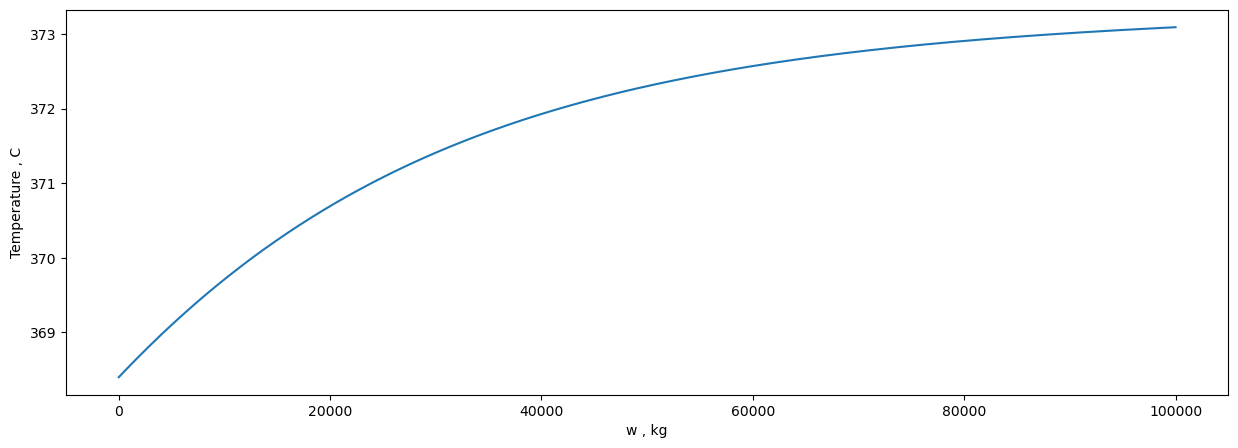

In [54]:
plt.figure(figsize=(15 , 5))
plt.plot(w , T - 273.15)
plt.xlabel("w , kg")
plt.ylabel("Temperature , C")
#plt.xticks(np.arange(0 , 50000 , 1000))

Text(0, 0.5, 'H2 consumed , kmole/hr')

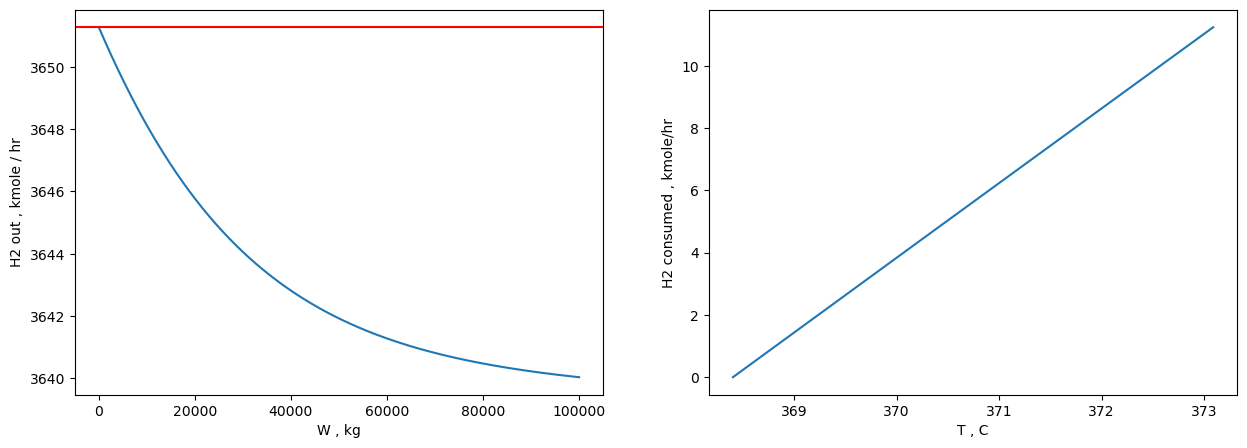

In [55]:
plt.figure(figsize=(15 , 5))
plt.subplot(1 , 2 , 1)
plt.plot(w , F_H2)
plt.xlabel("W , kg")
plt.ylabel("H2 out , kmole / hr")
plt.axhline(FH2_o , color = "r")
plt.subplot(1,2,2)
plt.plot(T-273.15 , FH2_o - F_H2)
plt.xlabel("T , C")
plt.ylabel("H2 consumed , kmole/hr")
#plt.axhline(FH2_o)
#plt.axhline(FH2_o , color = "r")

Text(0, 0.5, 'VGO liquid out , kmole/hr')

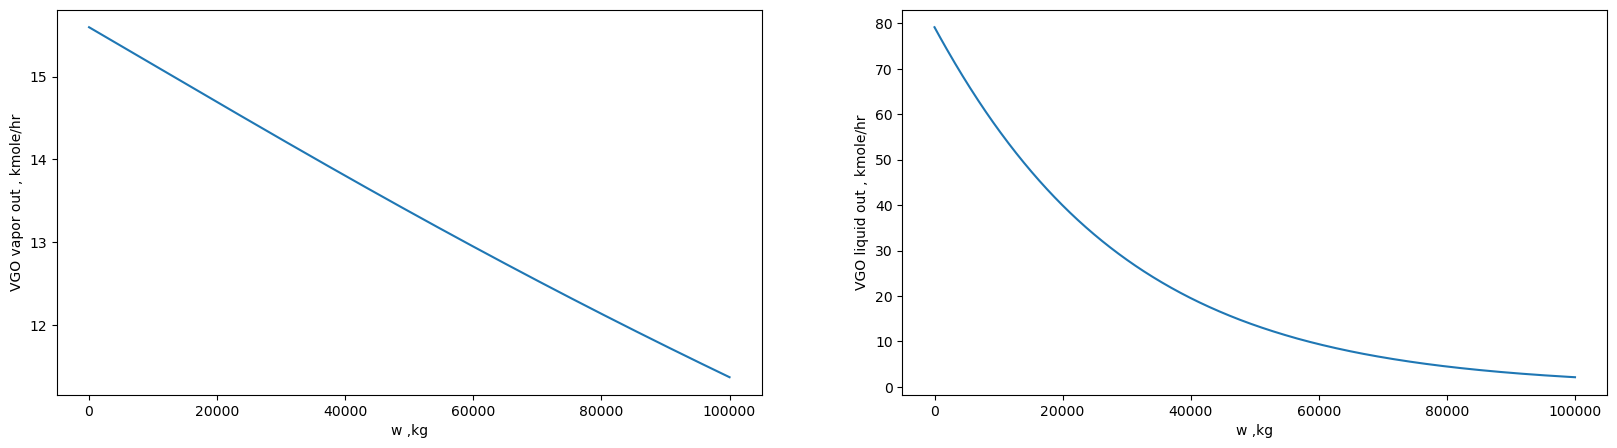

In [56]:
plt.figure(figsize=(20, 5))
plt.subplot(1 , 2 , 1)
plt.plot(w , FF_vap)
plt.xlabel("w ,kg")
plt.ylabel("VGO vapor out , kmole/hr")

plt.subplot(1 , 2 , 2)
plt.plot(w , FF_liq)
plt.xlabel("w ,kg")
plt.ylabel("VGO liquid out , kmole/hr")

Text(0, 0.5, 'conversion')

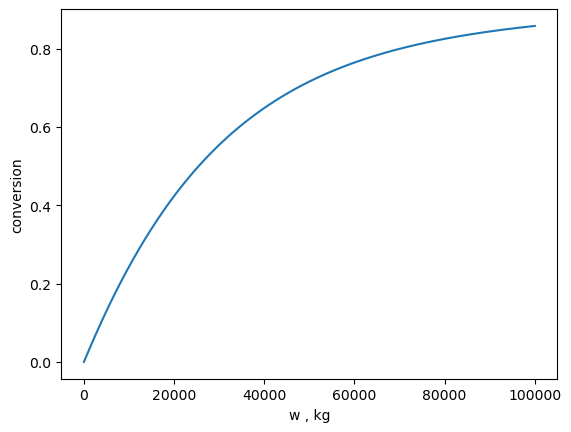

In [57]:
x = (FF_vap_o + FF_liq_o - FF_vap - FF_liq) / (FF_liq_o + FF_vap_o)
plt.plot(w , x)
plt.xlabel("w , kg")
plt.ylabel("conversion")


In [58]:
a = np.argmax(FD_liq)
print(f"opt w is {w[a]} , opt temp is {T[a] - 273.15}")

opt w is 12987.6001 , opt temp is 370.0368153899667


In [59]:
print(max(FD_liq) , w[np.argmax(FD_liq)])

101.79975545282417 12987.6001


Text(0, 0.5, 'Diesel liquid out , kmole/hr')

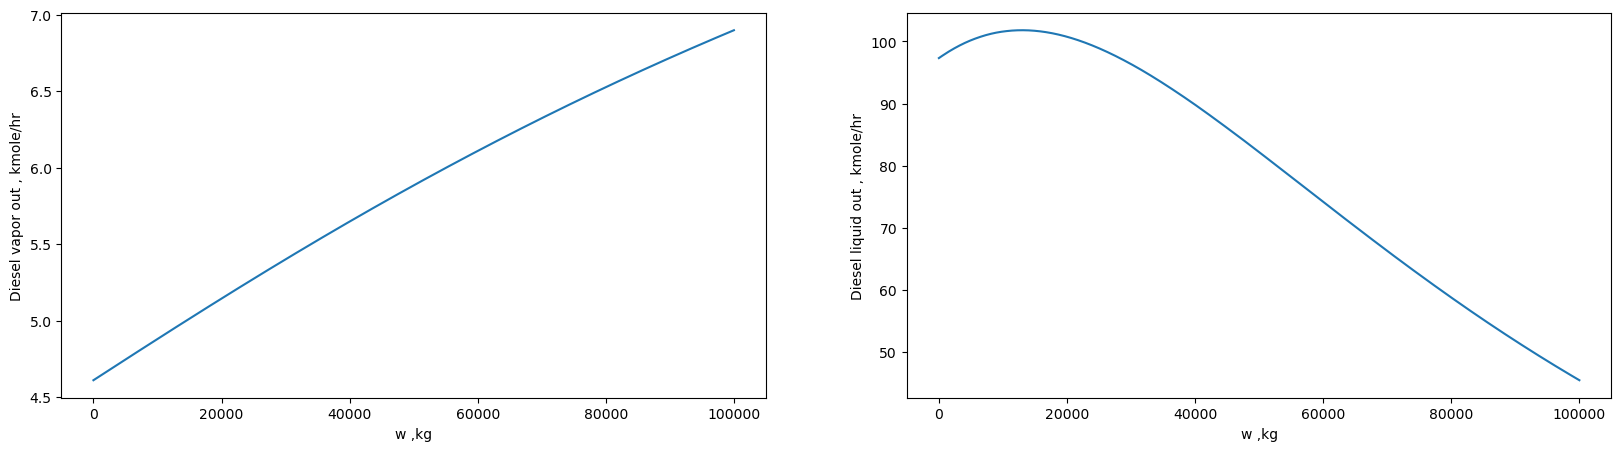

In [60]:
plt.figure(figsize=(20, 5))
plt.subplot(1 , 2 , 1)
plt.plot(w , FD_vap)
plt.xlabel("w ,kg")
plt.ylabel("Diesel vapor out , kmole/hr")

plt.subplot(1 , 2 , 2)
plt.plot(w , FD_liq)
plt.xlabel("w ,kg")
plt.ylabel("Diesel liquid out , kmole/hr")

Text(0, 0.5, 'Kerosene liquid out , kmole/hr')

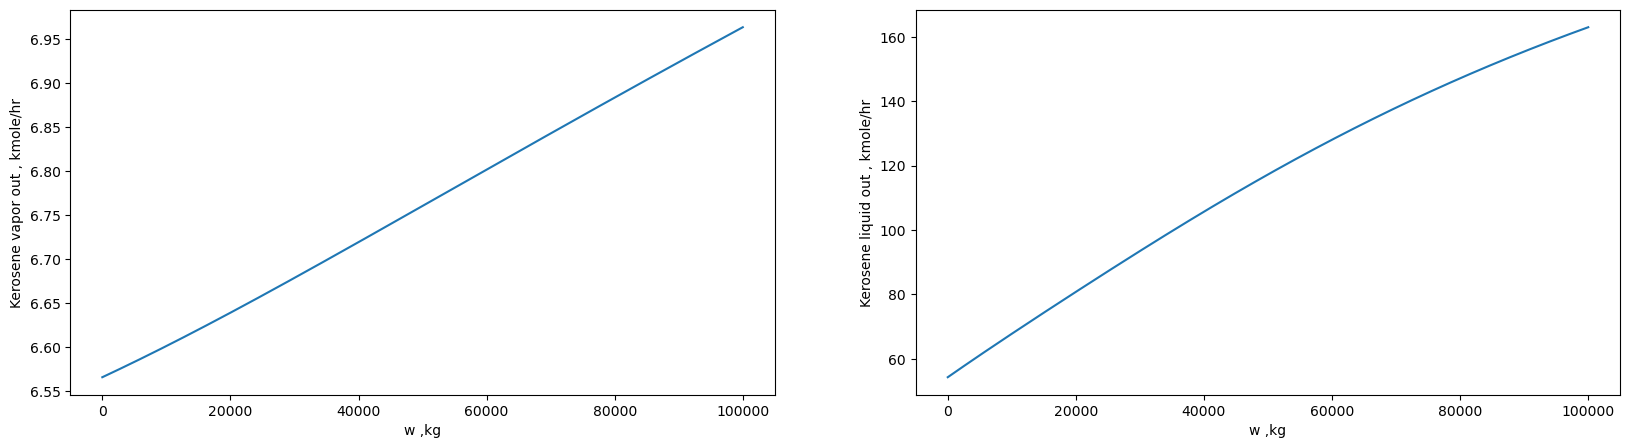

In [61]:
plt.figure(figsize=(20, 5))
plt.subplot(1 , 2 , 1)
plt.plot(w , FK_vap)
plt.xlabel("w ,kg")
plt.ylabel("Kerosene vapor out , kmole/hr")

plt.subplot(1 , 2 , 2)
plt.plot(w , FK_liq)
plt.xlabel("w ,kg")
plt.ylabel("Kerosene liquid out , kmole/hr")

Text(0, 0.5, 'Naphtha liquid out , kmole/hr')

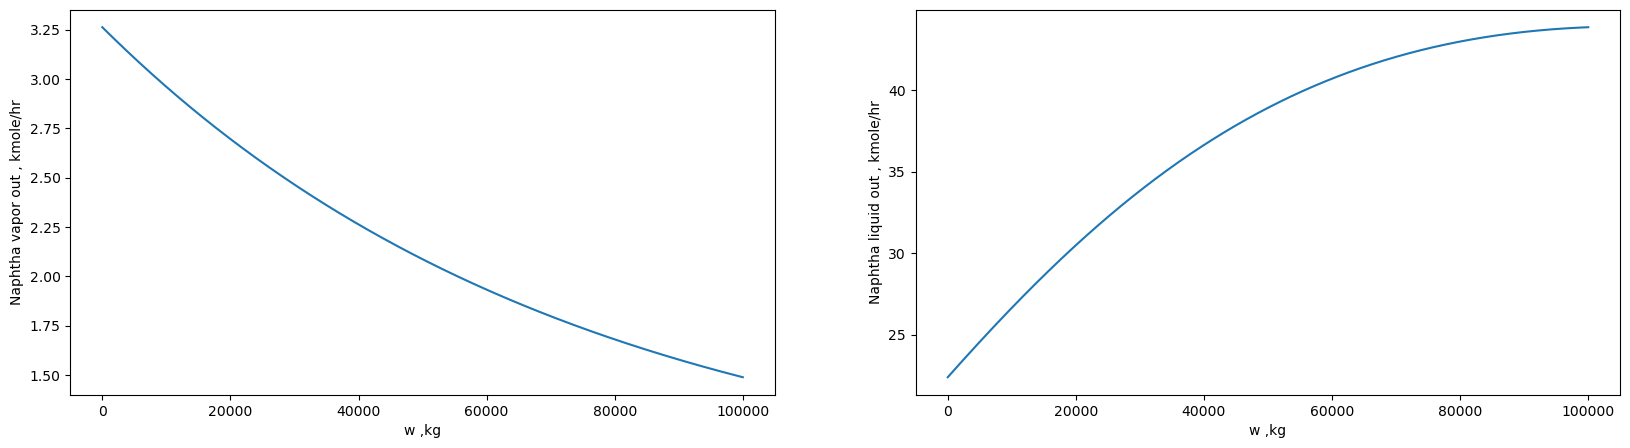

In [62]:
plt.figure(figsize=(20, 5))
plt.subplot(1 , 2 , 1)
plt.plot(w , FN_vap)
plt.xlabel("w ,kg")
plt.ylabel("Naphtha vapor out , kmole/hr")

plt.subplot(1 , 2 , 2)
plt.plot(w , FN_liq)
plt.xlabel("w ,kg")
plt.ylabel("Naphtha liquid out , kmole/hr")

Text(0, 0.5, 'GAS liquid out , kmole/hr')

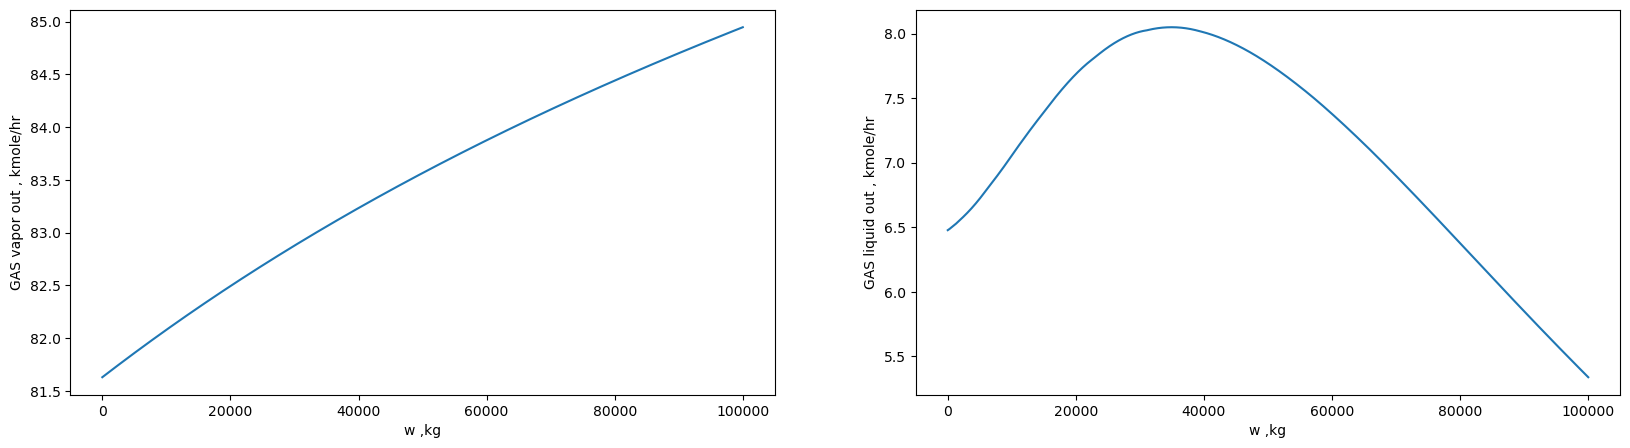

In [63]:
plt.figure(figsize=(20, 5))
plt.subplot(1 , 2 , 1)
plt.plot(w , FG_vap)
plt.xlabel("w ,kg")
plt.ylabel("GAS vapor out , kmole/hr")

plt.subplot(1 , 2 , 2)
plt.plot(w , FG_liq)
plt.xlabel("w ,kg")
plt.ylabel("GAS liquid out , kmole/hr")

Text(0, 0.5, 'pressure out , bar')

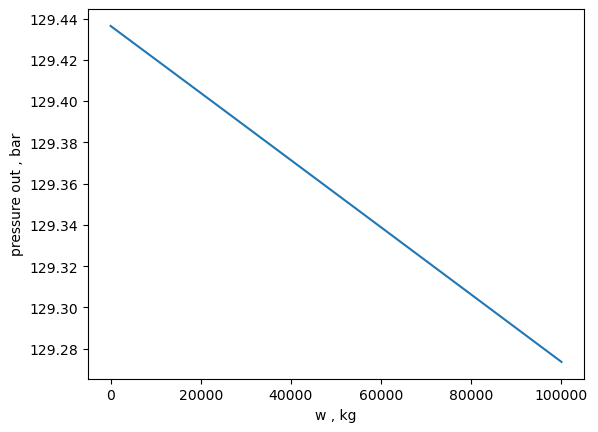

In [64]:
plt.plot(w , p)
plt.xlabel("w , kg")
plt.ylabel("pressure out , bar")

In [65]:
def max_diesel(FF_vap , FD_vap , FK_vap , FN_vap , FG_vap , FF_liq , FD_liq , FN_liq , FG_liq , FK_liq , p , T   ,F_H2):
    max_idx_D = np.argmax(FD_liq)
    w_ = w[max_idx_D]
    FF_vap_=FF_vap[max_idx_D]
    FD_vap_=FD_vap[max_idx_D]
    FK_vap_=FK_vap[max_idx_D]
    FN_vap_=FN_vap[max_idx_D]
    FG_vap_=FG_vap[max_idx_D]
    FF_liq_=FF_liq[max_idx_D]
    FD_liq_=max(FD_liq)
    FN_liq_=FN_liq[max_idx_D]
    FG_liq_=FG_liq[max_idx_D]
    FK_liq_=FK_liq[max_idx_D]
    p_ =p[max_idx_D]
    T_ =T[max_idx_D]
    F_H2_=F_H2[max_idx_D]

    FF_vap_o = 16.809283225448684 #edited after each bed
    FF_liq_o = 180.0680893066892 #edited after each bed
    x = (FF_vap_o + FF_liq_o - FF_vap_ - FF_liq_) / (FF_liq_o + FF_vap_o)

    return w_ , FF_vap_ , FD_vap_ , FK_vap_ , FN_vap_ , FG_vap_ , FF_liq_ , FD_liq_ , FN_liq_ , FG_liq_ , FK_liq_ , p_ , T_  ,F_H2_ , x
    


In [66]:
w_ , FF_vap_ , FD_vap_ , FK_vap_ , FN_vap_ , FG_vap_ , FF_liq_ , FD_liq_ , FN_liq_ , FG_liq_ , FK_liq_ , p_ , T_  ,F_H2_ , x = max_diesel(FF_vap , FD_vap , FK_vap , FN_vap , FG_vap , FF_liq , FD_liq , FN_liq , FG_liq , FK_liq , p , T   ,F_H2)

{"w" : w_ , "Fvgo_vap":FF_vap_ , "fd_vap":FD_vap_ , "fk_vap":FK_vap_ , "fn_vap":FN_vap_ , "fg_vap":FG_vap_ , "f_vgo_liq":FF_liq_ , "fd_liq":FD_liq_ , "fn_liq":FN_liq_ , "fg_liq":FG_liq_ , "fk_liq":FK_liq_ , "p":p_ , "temp_C":T_-273.15  ,"F_H2":F_H2_, "conversion" : x}

{'w': 12987.6001,
 'Fvgo_vap': 15.009556923128077,
 'fd_vap': 4.959186250427395,
 'fk_vap': 6.612107051937116,
 'fn_vap': 2.8778275712876296,
 'fg_vap': 82.2056876793439,
 'f_vgo_liq': 51.02910263480947,
 'fd_liq': 101.79975545282417,
 'fn_liq': 27.8436753774142,
 'fg_liq': 7.2614920233228935,
 'fk_liq': 71.71122168120425,
 'p': 129.41535221789664,
 'temp_C': 370.0368153899667,
 'F_H2': 3647.3471069259194,
 'conversion': 0.6645695810108522}

In [69]:
import os
os.getcwd()

'd:\\graduation project\\hydrocracker design'

In [72]:
# Load the variable from the file
import pickle

with open('T_BED1.pkl', 'rb') as file:
    T_BED1 = pickle.load(file)

with open('T_BED2.pkl', 'rb') as file:
    T_BED2 = pickle.load(file)

with open('T_BED3.pkl', 'rb') as file:
    T_BED3 = pickle.load(file)

with open('W_BED1.pkl', 'rb') as file:
    W_BED1 = pickle.load(file)

with open('W_BED2.pkl', 'rb') as file:
    W_BED2 = pickle.load(file)

with open('W_BED3.pkl', 'rb') as file:
    W_BED3 = pickle.load(file)

In [111]:
idx_cat_stop = np.max(np.where(w < 0.5 * 21747.200100000002 ))
T_BED4 = T[0 : idx_cat_stop]
W_BED4 = w[0 : idx_cat_stop]

In [110]:
W_BED4

array([1.00000000e-04, 2.00100000e-01, 4.00100000e-01, ...,
       1.08728001e+04, 1.08730001e+04, 1.08732001e+04])

In [109]:
T_BED4

array([641.55      , 641.55003015, 641.55006029, ..., 642.9598382 ,
       642.95986035, 642.9598825 ])

([<matplotlib.axis.XTick at 0x2142e2c0e10>,
 [Text(0.0, 0, '0'),
  Text(5000.0, 0, '5000'),
  Text(10000.0, 0, '10000'),
  Text(15000.0, 0, '15000'),
  Text(20000.0, 0, '20000'),
  Text(25000.0, 0, '25000'),
  Text(30000.0, 0, '30000'),
  Text(35000.0, 0, '35000'),
  Text(40000.0, 0, '40000'),
  Text(45000.0, 0, '45000')])

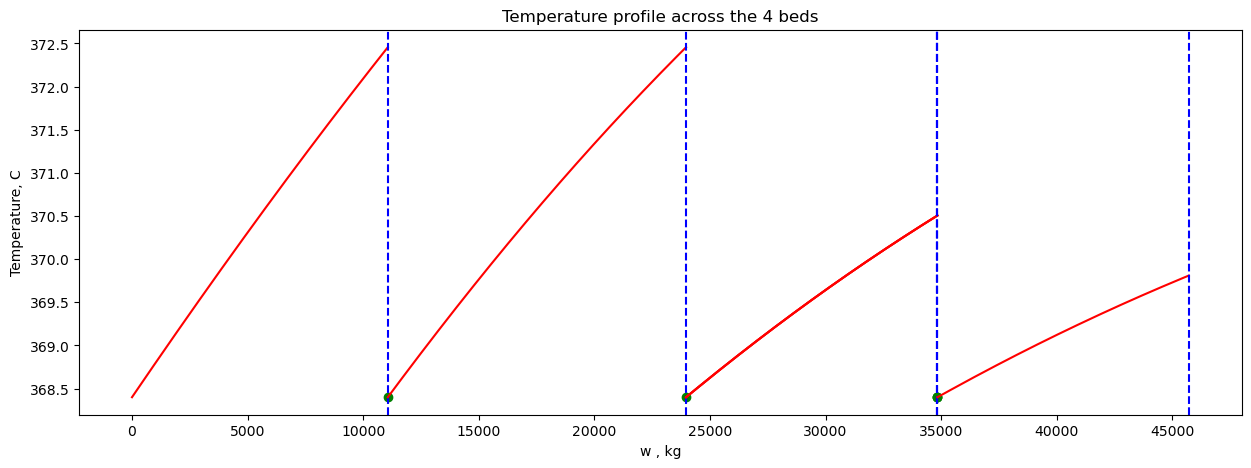

In [123]:
plt.figure(figsize=(15 , 5))
plt.plot(W_BED1 , T_BED1 - 273.15 , color = "red")
#plt.plot([W_BED1[-1]] * len(W_BED1) , np.array([T_BED1[0]] * len(T_BED1) )- 273.15)
plt.axvline(W_BED1[-1] , color = "blue" , linestyle = '--')
plt.scatter(W_BED1[-1],368.4 , color = "green")

plt.plot(W_BED2 + W_BED1[-1] , T_BED2 - 273.15 , color = "red")
plt.axvline(W_BED2[-1] +  W_BED1[-1], color = "blue" , linestyle = '--')
plt.scatter(W_BED2[-1]+  W_BED1[-1],368.4 , color = "green")

plt.plot(W_BED3 + W_BED2[-1] + W_BED1[-1] , T_BED3 - 273.15 , color = "red")
plt.axvline(W_BED3[-1] +  W_BED2[-1]  + W_BED1[-1], color = "blue" , linestyle = '--')
plt.scatter(W_BED3[-1] +  W_BED2[-1]  + W_BED1[-1],368.4 , color = "green")

plt.plot(W_BED3 + W_BED2[-1] + W_BED1[-1] , T_BED3 - 273.15 , color = "red")
plt.axvline(W_BED3[-1] +  W_BED2[-1]  + W_BED1[-1], color = "blue" , linestyle = '--')
plt.scatter(W_BED3[-1] +  W_BED2[-1]  + W_BED1[-1],368.4 , color = "green")

plt.plot(W_BED3 + W_BED2[-1] + W_BED1[-1] , T_BED3 - 273.15 , color = "red")
plt.axvline(W_BED3[-1] +  W_BED2[-1]  + W_BED1[-1], color = "blue" , linestyle = '--')
plt.scatter(W_BED3[-1] +  W_BED2[-1]  + W_BED1[-1],368.4 , color = "green")

plt.plot(W_BED4 + W_BED3[-1] + W_BED2[-1] + W_BED1[-1] , T_BED4 - 273.15 , color = "red")
plt.axvline(W_BED4[-1] +  W_BED3[-1]  + W_BED2[-1] + + W_BED1[-1], color = "blue" , linestyle = '--')
#plt.scatter(W_BED4[-1] +W_BED3[-1] +  W_BED2[-1]  + W_BED1[-1],368.4 , color = "green")

plt.title("Temperature profile across the 4 beds")
plt.xlabel("w , kg")
plt.ylabel("Temperature, C")

plt.xticks(np.arange(0 , W_BED4[-1] +  W_BED3[-1]  + W_BED2[-1] + + W_BED1[-1] , 5000))

def max_temp(FF_vap , FD_vap , FK_vap , FN_vap , FG_vap , FF_liq , FD_liq , FN_liq , FG_liq , FK_liq , p , T   ,F_H2):
    
    rise = 380.5691282842647 - (368.4)
    rise_per_bed = rise/3
    temp_stop = rise_per_bed + 368.4
    idx_temp_stop = np.max(np.where(T<372.456+273.15))

    w_ = w[idx_temp_stop]
    FF_vap_=FF_vap[idx_temp_stop]
    FD_vap_=FD_vap[idx_temp_stop]
    FK_vap_=FK_vap[idx_temp_stop]
    FN_vap_=FN_vap[idx_temp_stop]
    FG_vap_=FG_vap[idx_temp_stop]
    FF_liq_=FF_liq[idx_temp_stop]
    FD_liq_=FD_liq[idx_temp_stop]
    FN_liq_=FN_liq[idx_temp_stop]
    FG_liq_=FG_liq[idx_temp_stop]
    FK_liq_=FK_liq[idx_temp_stop]
    p_ =p[idx_temp_stop]
    T_ =T[idx_temp_stop]
    F_H2_=F_H2[idx_temp_stop]

    FF_vap_o = 17.40854988 #edited after each bed
    FF_liq_o = 242.4937994 #edited after each bed
    x = (FF_vap_o + FF_liq_o - FF_vap_ - FF_liq_) / (FF_liq_o + FF_vap_o)

    return w_ , FF_vap_ , FD_vap_ , FK_vap_ , FN_vap_ , FG_vap_ , FF_liq_ , FD_liq_ , FN_liq_ , FG_liq_ , FK_liq_ , p_ , T_  ,F_H2_ , x

w_ , FF_vap_ , FD_vap_ , FK_vap_ , FN_vap_ , FG_vap_ , FF_liq_ , FD_liq_ , FN_liq_ , FG_liq_ , FK_liq_ , p_ , T_  ,F_H2_ , x = max_temp(FF_vap , FD_vap , FK_vap , FN_vap , FG_vap , FF_liq , FD_liq , FN_liq , FG_liq , FK_liq , p , T   ,F_H2)

{"w" : w_ , "Fvgo_vap":FF_vap_ , "fd_vap":FD_vap_ , "fk_vap":FK_vap_ , "fn_vap":FN_vap_ , "fg_vap":FG_vap_ , "f_vgo_liq":FF_liq_ , "fd_liq":FD_liq_ , "fn_liq":FN_liq_ , "fg_liq":FG_liq_ , "fk_liq":FK_liq_ , "p":p_ , "temp_C":T_-273.15  ,"F_H2":F_H2_, "conversion" : x}

#flow rates
Fvgo_vap = 15.840102483329341
fd_vap   = 4.463853976824296
fk_vap   = 6.545354265675065
fn_vap   = 3.4293178177902788
fg_vap   = 81.38578465171908
f_vgo_liq= 52.654321656969614
fd_liq   = 101.08297105104931
fn_liq   = 27.567904370967565
fg_liq   = 7.764397700601099
fk_liq   = 70.57487224343332
f_r_liq  = 4.745247617
f_r_vap  = 0.005588344
F_H2      =3259.362083176698
F_H2S_liq = 18.06256176
F_H2S_vap = 297.7673451
F_NH3_vap = 2.52506041
F_NH3_liq = 0.149586238